In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sys
import warnings

import plotly.io as pio
import plotly.express as px

from matplotlib import pyplot as plt
from dotenv import load_dotenv
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

sys.path.append("../")

from scripts.order_operations import get_min_max_dt, get_order_details  # Shows error but its ok, trust me
from scripts.optimizers_mp import k_means_optimizer  # Same Same

data_path = "../data"

pio.renderers.default = "notebook_connected"

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


# 1 : Introduction

# 2 : DataFrame creation, RFM logic

# 3 : Early visualisations

# 4 : Applying classification algorithms (K-Means, DBSCAN, Agglomerative clustering)

# 5 : Conclusions and potential improvements

# <u>1 : Introduction :</u>

&emsp;The attempt of this notebook is focused on the widespread approach : RFM (Recency Frequency Monetary). Usual classifications using traditionnal (and fundamentaly flawed) approaches will likely be atempted, like the Paretto distribution.<br>

&emsp;Using RMF approach, we will first attempt to distinguish classes with the data AS IS - This is expected to produce poor results. We will then evolve towards classifying machine learning algorithms which use more resources but produce, in general, better results.<br>

&emsp;It is expected that the data provided by this approach will be insufficient but will provide a good raw material to improve the models by improving the data quality and the algorithms.

# <u>2 : DataFrame creation, RFM logic</u>

&emsp;The usage of RFM presupposes that we have the data to calculate the 3 indicators (R F & M). Not all datasets will be required for this step and there is no need to clog up the memory as the calculation time/resource is expected to go up.<br>
&emsp;Will be required : <br>
- olist_customers : will provide the link between the unique customer and it's aliases (and orders) - The goal is to eliminate the useless repetitivity of the alias.
- olist_orders : will provide the link between the customer (referred sometimes as cx.) and the order itself - The date the order was placed and which alias placed the order.
- olist_order_items : will provide what items were ordered at what price, determining the monetary component of each order

<hr>

<i>
&emsp;The Recency will be defined by the time separating the most recent update from a Cx and the most recent update known - In this approach, we assume that the latest order placed is the most recent order (instead of using t0 = today).<br>
&emsp;The Frequency will be : number_of_orders/membership_time. membership_time is : time elapsed between first order of account and last general order(not last order of account). If Cx has only placed just one order, frequency will be 0.<br>
&emsp;Monetary will be the total of all item prices of all orders placed by a customer, Kaggle shows that freight is always paid (case where Cx orders 10 times the same item from the same seller --> Cx will pay 10 times the freight price).
</i>

In [2]:
olist_customers_file = "../data/optimized/olist_customers.csv"
olist_orders_file = "../data/optimized/olist_orders.csv"
olist_order_items_file = "../data/optimized/olist_order_items.csv"


In [3]:
df_customers = pd.read_csv(filepath_or_buffer=olist_customers_file)
df_orders = pd.read_csv(filepath_or_buffer=olist_orders_file)
df_orders_items = pd.read_csv(filepath_or_buffer=olist_order_items_file)


In [4]:
# Dtypes were not carried over and will need to be enforced
# Or using pickles rather than CSV

df_customers["customer_id"] = df_customers["customer_id"].astype(np.uint32)
df_customers["customer_unique_id"] = df_customers["customer_unique_id"].astype(np.uint32)


In [5]:
df_customers.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  uint32
 1   customer_unique_id        99441 non-null  uint32
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(2), uint32(2)
memory usage: 3.0+ MB


In [6]:
df_customers.head()


customer_id  customer_unique_id  customer_zip_code_prefix  \
0            1                   1                     14409   
1            2                   2                      9790   
2            3                   3                      1151   
3            4                   4                      8775   
4            5                   5                     13056   

           customer_city customer_state  
0                 franca             SP  
1  sao bernardo do campo             SP  
2              sao paulo             SP  
3        mogi das cruzes             SP  
4               campinas             SP

In [7]:
date_cols = [
        "order_purchase_dt", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ]

for col in date_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])

df_orders["order_id"] = df_orders["order_id"].astype(np.uint32)
df_orders["customer_id"] = df_orders["customer_id"].astype(np.uint32)


In [8]:
df_orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  uint32        
 1   customer_id                    99441 non-null  uint32        
 2   order_status                   99441 non-null  object        
 3   order_purchase_dt              99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(1), uint32(2)
memory usage: 5.3+ MB


In [9]:
df_orders.head()


order_id  customer_id order_status   order_purchase_dt   order_approved_at  \
0         1        70297    delivered 2017-10-02 10:56:33 2017-10-02 11:07:15   
1         2        77028    delivered 2018-07-24 20:41:37 2018-07-26 03:24:27   
2         3          555    delivered 2018-08-08 08:38:49 2018-08-08 08:55:23   
3         4        61082    delivered 2017-11-18 19:28:06 2017-11-18 19:45:59   
4         5        67264    delivered 2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

In [10]:
df_orders_items["order_id"] = df_orders_items["order_id"].astype(np.uint32)
df_orders_items["order_item_id"] = df_orders_items["order_item_id"].astype(np.uint32)
df_orders_items["product_id"] = df_orders_items["product_id"].astype(np.uint32)
df_orders_items["seller_id"] = df_orders_items["seller_id"].astype(np.uint32)

df_orders_items["shipping_limit_date"] = pd.to_datetime(df_orders_items["shipping_limit_date"])


In [11]:
df_orders_items.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  uint32        
 1   order_item_id        112650 non-null  uint32        
 2   product_id           112650 non-null  uint32        
 3   seller_id            112650 non-null  uint32        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), uint32(4)
memory usage: 4.3 MB


In [12]:
df_orders_items.head()


order_id  order_item_id  product_id  seller_id shipping_limit_date   price  \
0     85268              1       25866        514 2017-09-19 09:45:35   58.90   
1     71854              1       27231        472 2017-05-03 11:05:13  239.90   
2      6299              1       22625       1825 2018-01-18 14:48:30  199.00   
3     22551              1       15404       2024 2018-08-15 10:10:18   12.99   
4      5248              1        8863       1598 2017-02-13 13:57:51  199.90   

   freight_value  
0          13.29  
1          19.93  
2          17.87  
3          12.79  
4          18.14

In [13]:
# Starting point can be orders df, we will remove infos as we need

df_orders.head()


order_id  customer_id order_status   order_purchase_dt   order_approved_at  \
0         1        70297    delivered 2017-10-02 10:56:33 2017-10-02 11:07:15   
1         2        77028    delivered 2018-07-24 20:41:37 2018-07-26 03:24:27   
2         3          555    delivered 2018-08-08 08:38:49 2018-08-08 08:55:23   
3         4        61082    delivered 2017-11-18 19:28:06 2017-11-18 19:45:59   
4         5        67264    delivered 2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

In [14]:
# Cx id, order_id, order_purchase_dt are useful, the rest can go

df_orders = df_orders[["order_id", "customer_id", "order_purchase_dt"]]

df_orders["customer_uid"] = np.uint32(0)
df_orders["sum_total"] = np.nan

df_orders.head()


order_id  customer_id   order_purchase_dt  customer_uid  sum_total
0         1        70297 2017-10-02 10:56:33             0        NaN
1         2        77028 2018-07-24 20:41:37             0        NaN
2         3          555 2018-08-08 08:38:49             0        NaN
3         4        61082 2017-11-18 19:28:06             0        NaN
4         5        67264 2018-02-13 21:18:39             0        NaN

In [15]:
order_ids = df_orders["order_id"].unique()

for order_id in order_ids:
    index = df_orders.index[df_orders["order_id"] == order_id][0]
    order_value = df_orders_items[df_orders_items["order_id"] == order_id]["price"].sum()
    freight_value = df_orders_items[df_orders_items["order_id"] == order_id]["freight_value"].sum()
    df_orders.at[index, "sum_total"] = order_value + freight_value


In [16]:
# Setting customers unique ids instead of cx_ids

cx_ids = df_orders["customer_id"]

for cx_id in cx_ids:
    index = df_orders.index[df_orders["customer_id"] == cx_id][0]
    cx_uid = df_customers[df_customers["customer_id"] == cx_id]["customer_unique_id"]
    df_orders.at[index, "customer_uid"] = cx_uid


In [17]:
df_orders.head()


order_id  customer_id   order_purchase_dt  customer_uid  sum_total
0         1        70297 2017-10-02 10:56:33         68585      38.71
1         2        77028 2018-07-24 20:41:37         74977     141.46
2         3          555 2018-08-08 08:38:49           555     179.12
3         4        61082 2017-11-18 19:28:06         59790      72.20
4         5        67264 2018-02-13 21:18:39         65715      28.62

In [18]:
rfm_cols = ["customer_uid", "order_id_list", "most_ancient_order_dt", "most_recent_order_dt", "recency", "frequency", "monetary"]
df_rfm = pd.DataFrame(columns=rfm_cols)


In [19]:
uniques = df_orders["customer_uid"].unique()

uniques.sort()

df_rfm["customer_uid"] = uniques


In [20]:
for uid in uniques:
    index = df_rfm.index[df_rfm["customer_uid"] == uid][0]
    details = get_order_details(cx_uid=uid, uid_col="customer_uid", from_frame=df_orders)
    df_rfm.at[index, "order_id_list"] = details["order_list"]
    df_rfm.at[index, "monetary"] = details["total_spent"]


In [21]:
for tuple in df_rfm.itertuples():
    index = tuple.Index
    order_list = tuple.order_id_list
    min_max_dt = get_min_max_dt(order_list=order_list, from_frame=df_orders, dt_col="order_purchase_dt")
    df_rfm.at[index, "most_ancient_order_dt"] = min_max_dt["min"]
    df_rfm.at[index, "most_recent_order_dt"] = min_max_dt["max"]


In [22]:
most_recent_global = df_rfm["most_recent_order_dt"].max()


In [23]:
def get_recency(row, most_recent_global) -> pd.Timedelta:
    """
    Returns timedelta in seconds between most recent purchase global and most recent purchase cx
    """
    return (most_recent_global - row["most_recent_order_dt"]).total_seconds()


def get_frequency(row, most_recent_global):
    """
    Returns avg. purchases made per active month
    """
    if len(row["order_id_list"]) <= 1:
        return 0
    else:
        account_timespan = most_recent_global - row["most_ancient_order_dt"]
        return len(row["order_id_list"]) / (account_timespan.total_seconds() / 2419200)  # Purchase per active month


In [24]:
df_rfm["recency"] = df_rfm.apply(get_recency, axis=1, args=(most_recent_global, ))


In [25]:
df_rfm["frequency"] = df_rfm.apply(get_frequency, axis=1, args=(most_recent_global, ))


In [26]:
df_rfm.head()


customer_uid order_id_list most_ancient_order_dt most_recent_order_dt  \
0             1       [88493]   2017-05-16 15:05:35  2017-05-16 15:05:35   
1             2       [90419]   2018-01-12 20:48:24  2018-01-12 20:48:24   
2             3       [22558]   2018-05-19 16:07:45  2018-05-19 16:07:45   
3             4       [32181]   2018-03-13 16:06:38  2018-03-13 16:06:38   
4             5       [69903]   2018-07-29 09:51:30  2018-07-29 09:51:30   

      recency  frequency monetary  
0  44850283.0        0.0   146.87  
1  24007314.0        0.0   335.48  
2  13051353.0        0.0   157.73  
3  18840220.0        0.0    173.3  
4   6939528.0        0.0   252.25

#### Part 2 - conclusion :

- Many cells are not useful and can be safely deleted (all cells displaying dfs and head() / info())
- DataFrame created containing RFM values : 
    - Recency is delta T in seconds between Cx most recent order and Global most recent order
    - Frequency is purchases made / account creation to most recent order | In purchase per month
    - Monetary is total spent on all order, including freight which is -always- paid


# <u>3 : Early visualisations</u>

Goals : 
- Identify possible clusters using only RFM and scaling (most likely min-max scaler)
- Apply Pareto Principle (bs) : 20% of customers generate 80% of traffic
- Identify possibly lacking variables overlooked by RFM method (to be confirmed by part 4)
- Plot RFM two by two, then 3D attempt and/or radar

## 1 : Intuition : Most clients make just one purchase (Frequency = 0)

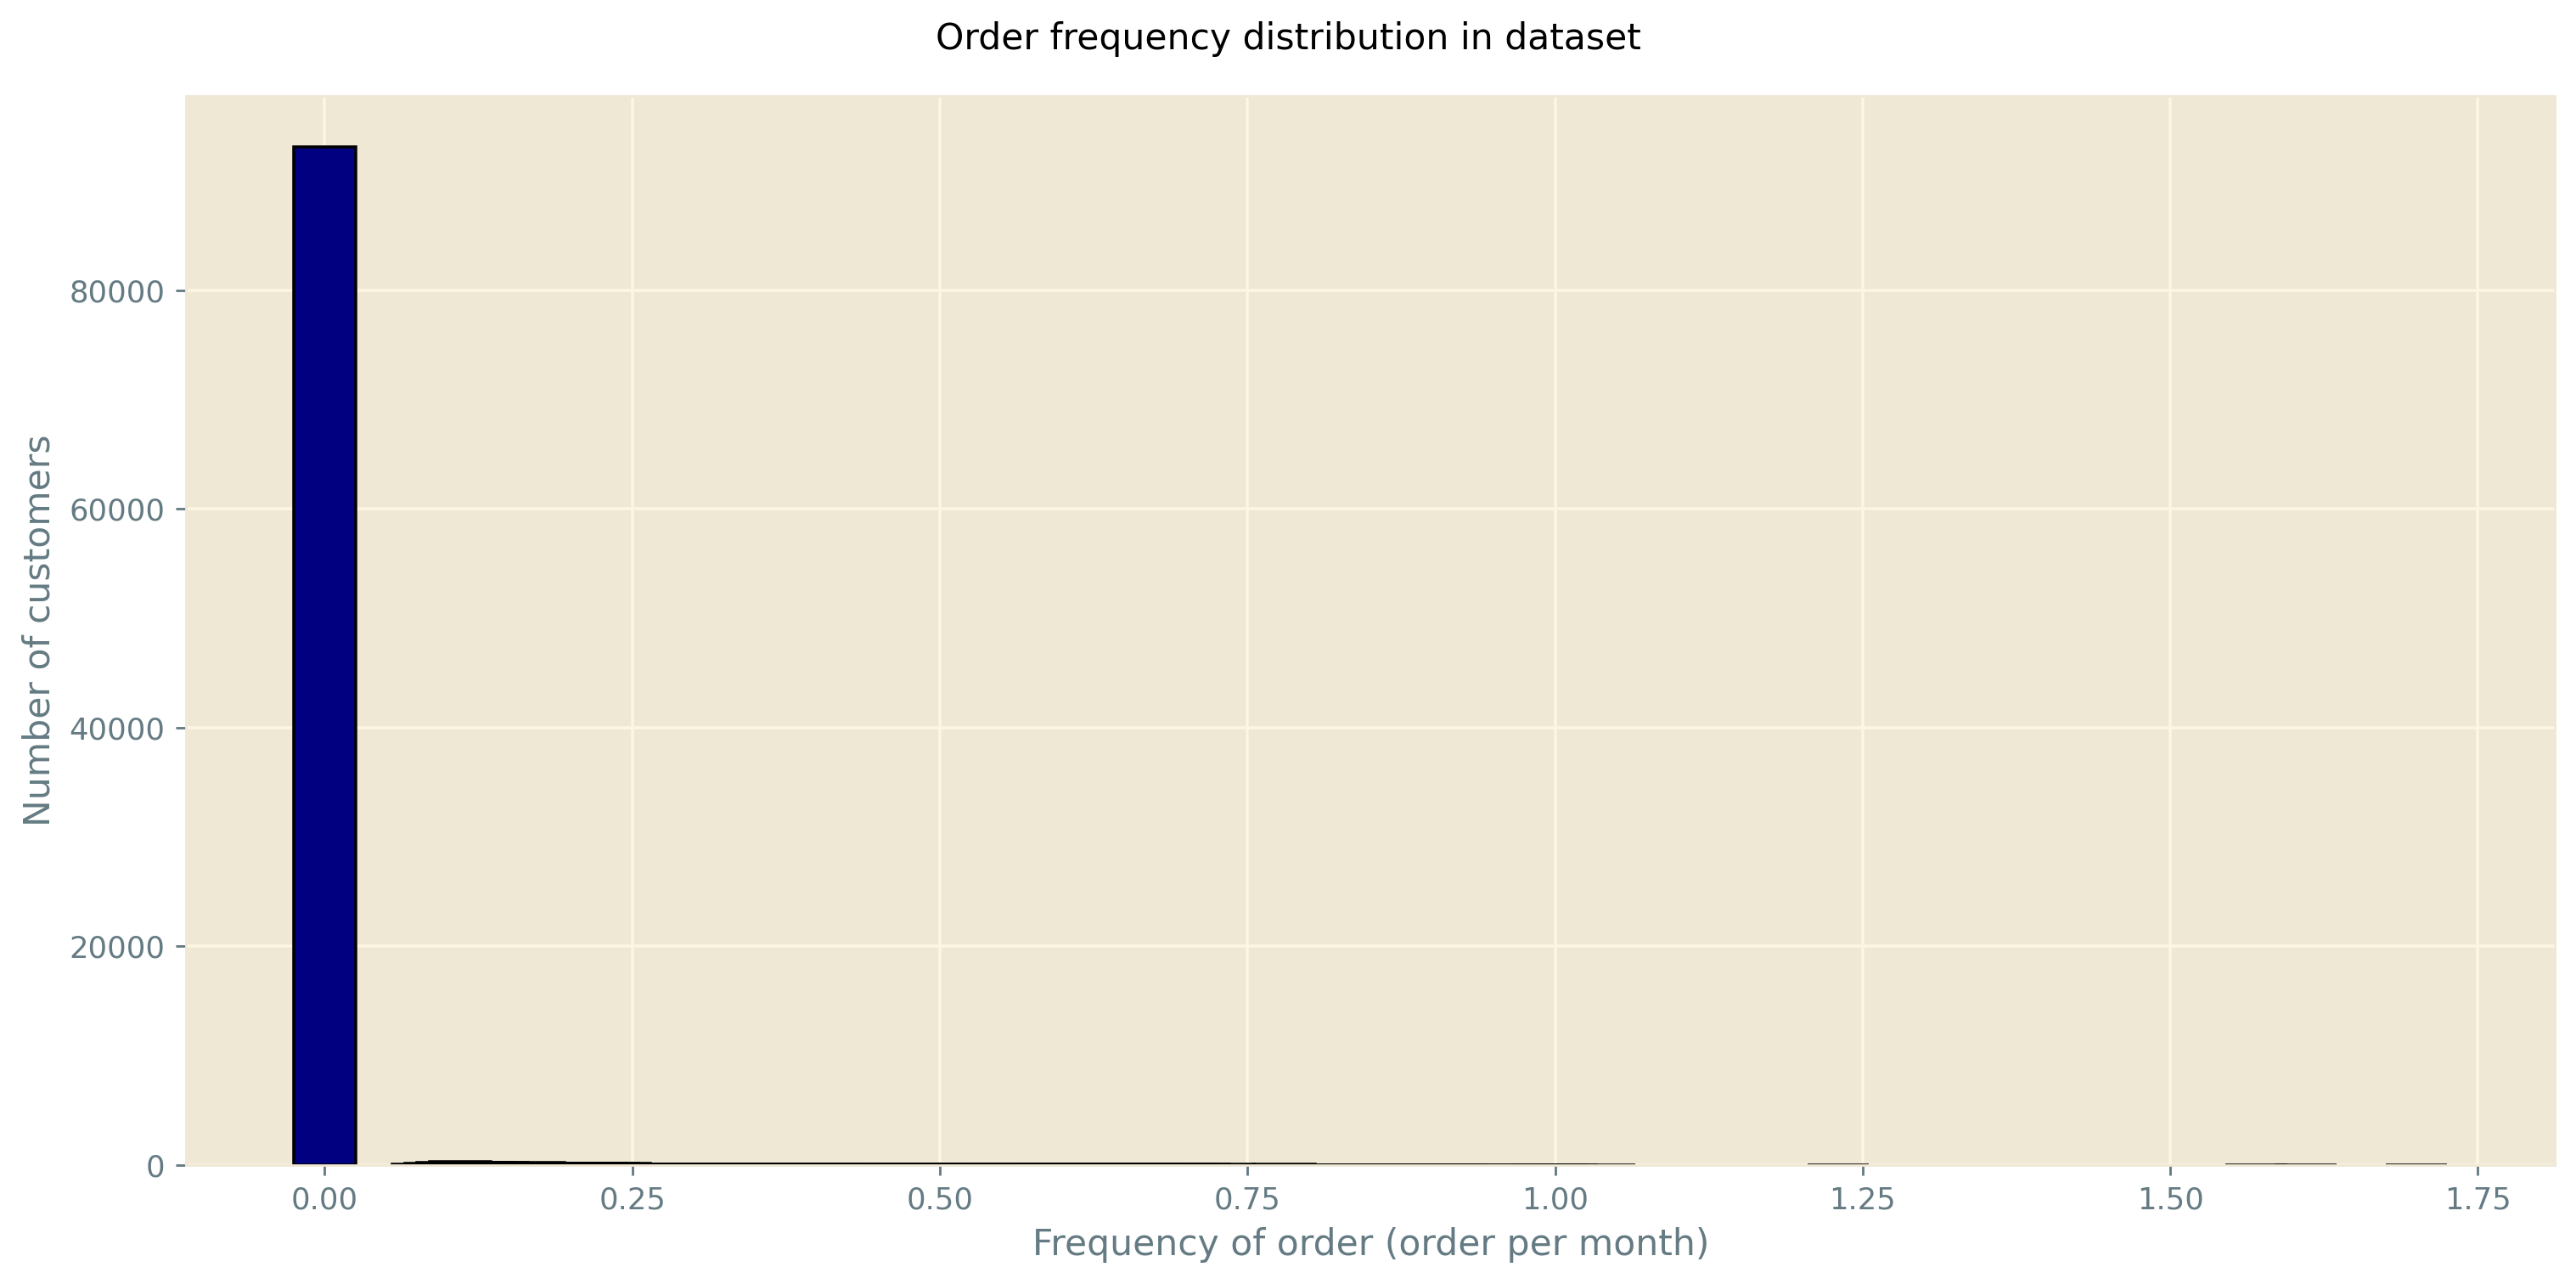

In [27]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12, 6),
    dpi=pc_dpi,
)

frequencies = df_rfm["frequency"].round(decimals=2).value_counts().to_dict()

ax1.bar(x=list(frequencies.keys()), height=frequencies.values(), width=.05, color="navy", edgecolor="black")

###
# Titles/Lables
ax1.set_xlabel("Frequency of order (order per month)")
ax1.set_ylabel("Number of customers")
fig.suptitle("Order frequency distribution in dataset")
#
###

fig.tight_layout()
plt.show()


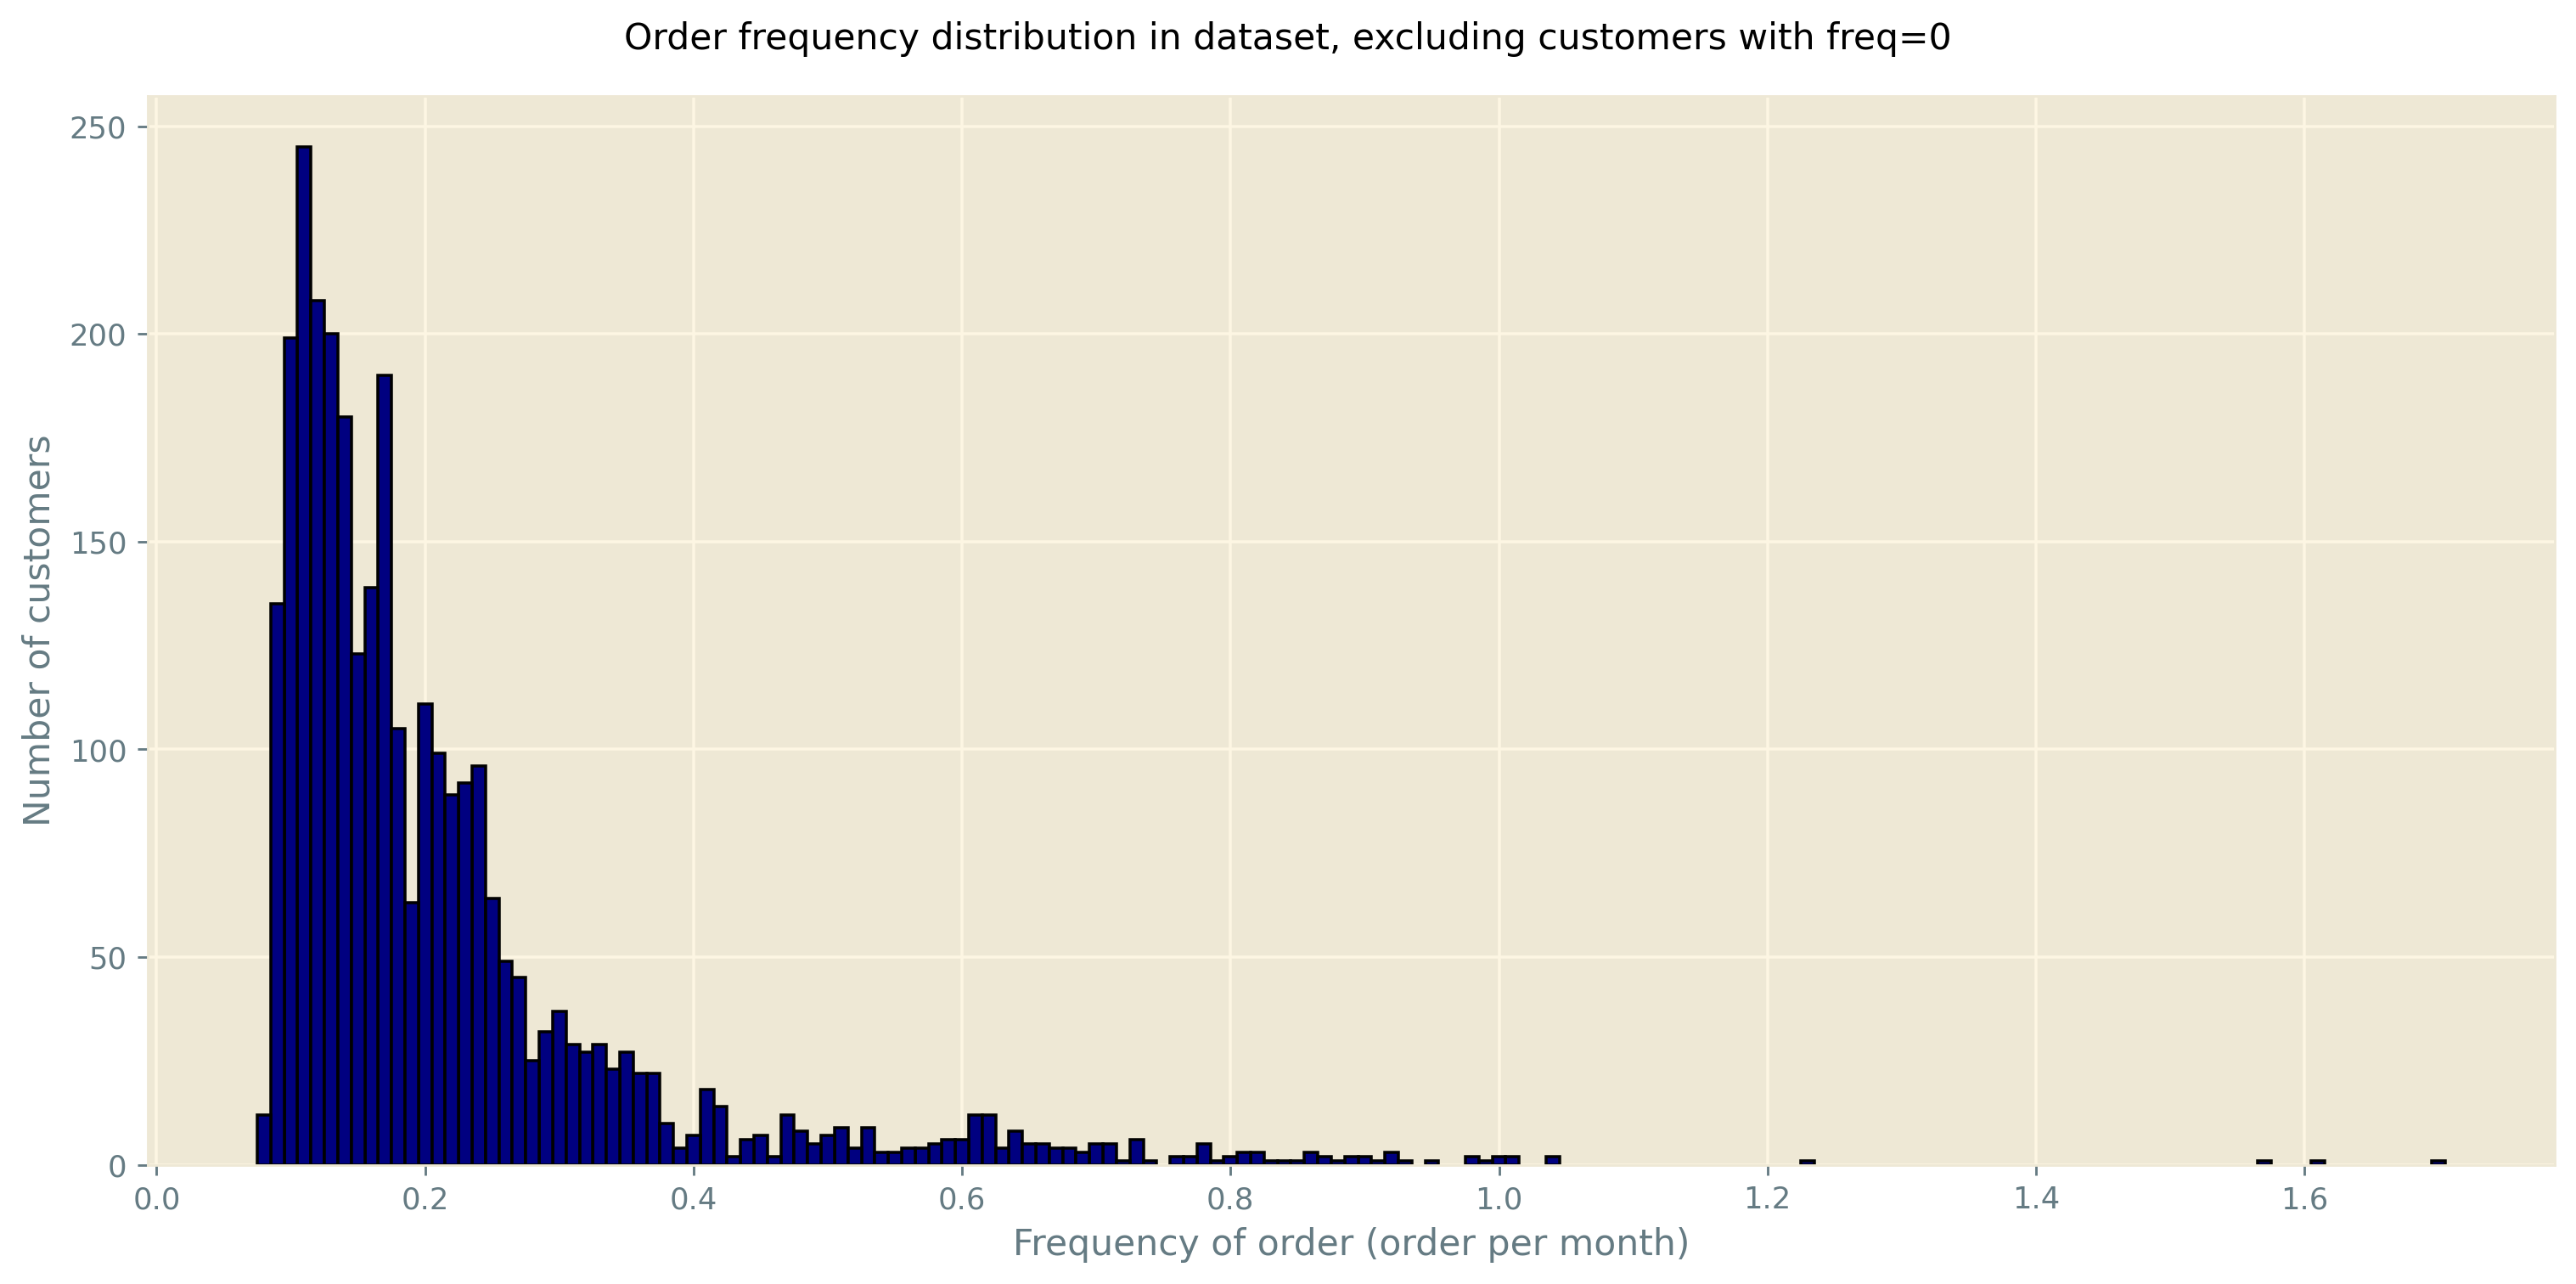

In [28]:
# Excluding 0 : 
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12, 6),
    dpi=pc_dpi,
)

try:
    frequencies.pop(0)
except KeyError:
    pass


ax1.bar(x=list(frequencies.keys()), height=frequencies.values(), width=.01, color="navy", edgecolor="black")

###
# Titles/Lables
ax1.set_xlabel("Frequency of order (order per month)")
ax1.set_ylabel("Number of customers")
fig.suptitle("Order frequency distribution in dataset, excluding customers with freq=0")
#
###

fig.tight_layout()
plt.show()


### Observations : 

&emsp;Clearly, olist has either problems keeping customers "loyals" or it is easier to create a new account each visit. In any case, the amount of customers who made exactly one purchase is crushingly larger than all other customers combined, regardless of frequency (93099 customers).
&emsp;Excluding customers who made exactly one purchase, the majority of remaining customers order on olist between .1 and .4 times a month (between 1.1 and 4.8 times a year). There are extremes ordering up to 1.7 times a month. But these customers are extremely rare.

- Operating under the assumption that Olist did not provide its whole database dump, early conclusions cannot be drawn.

## 2 : How much have customers spent ?


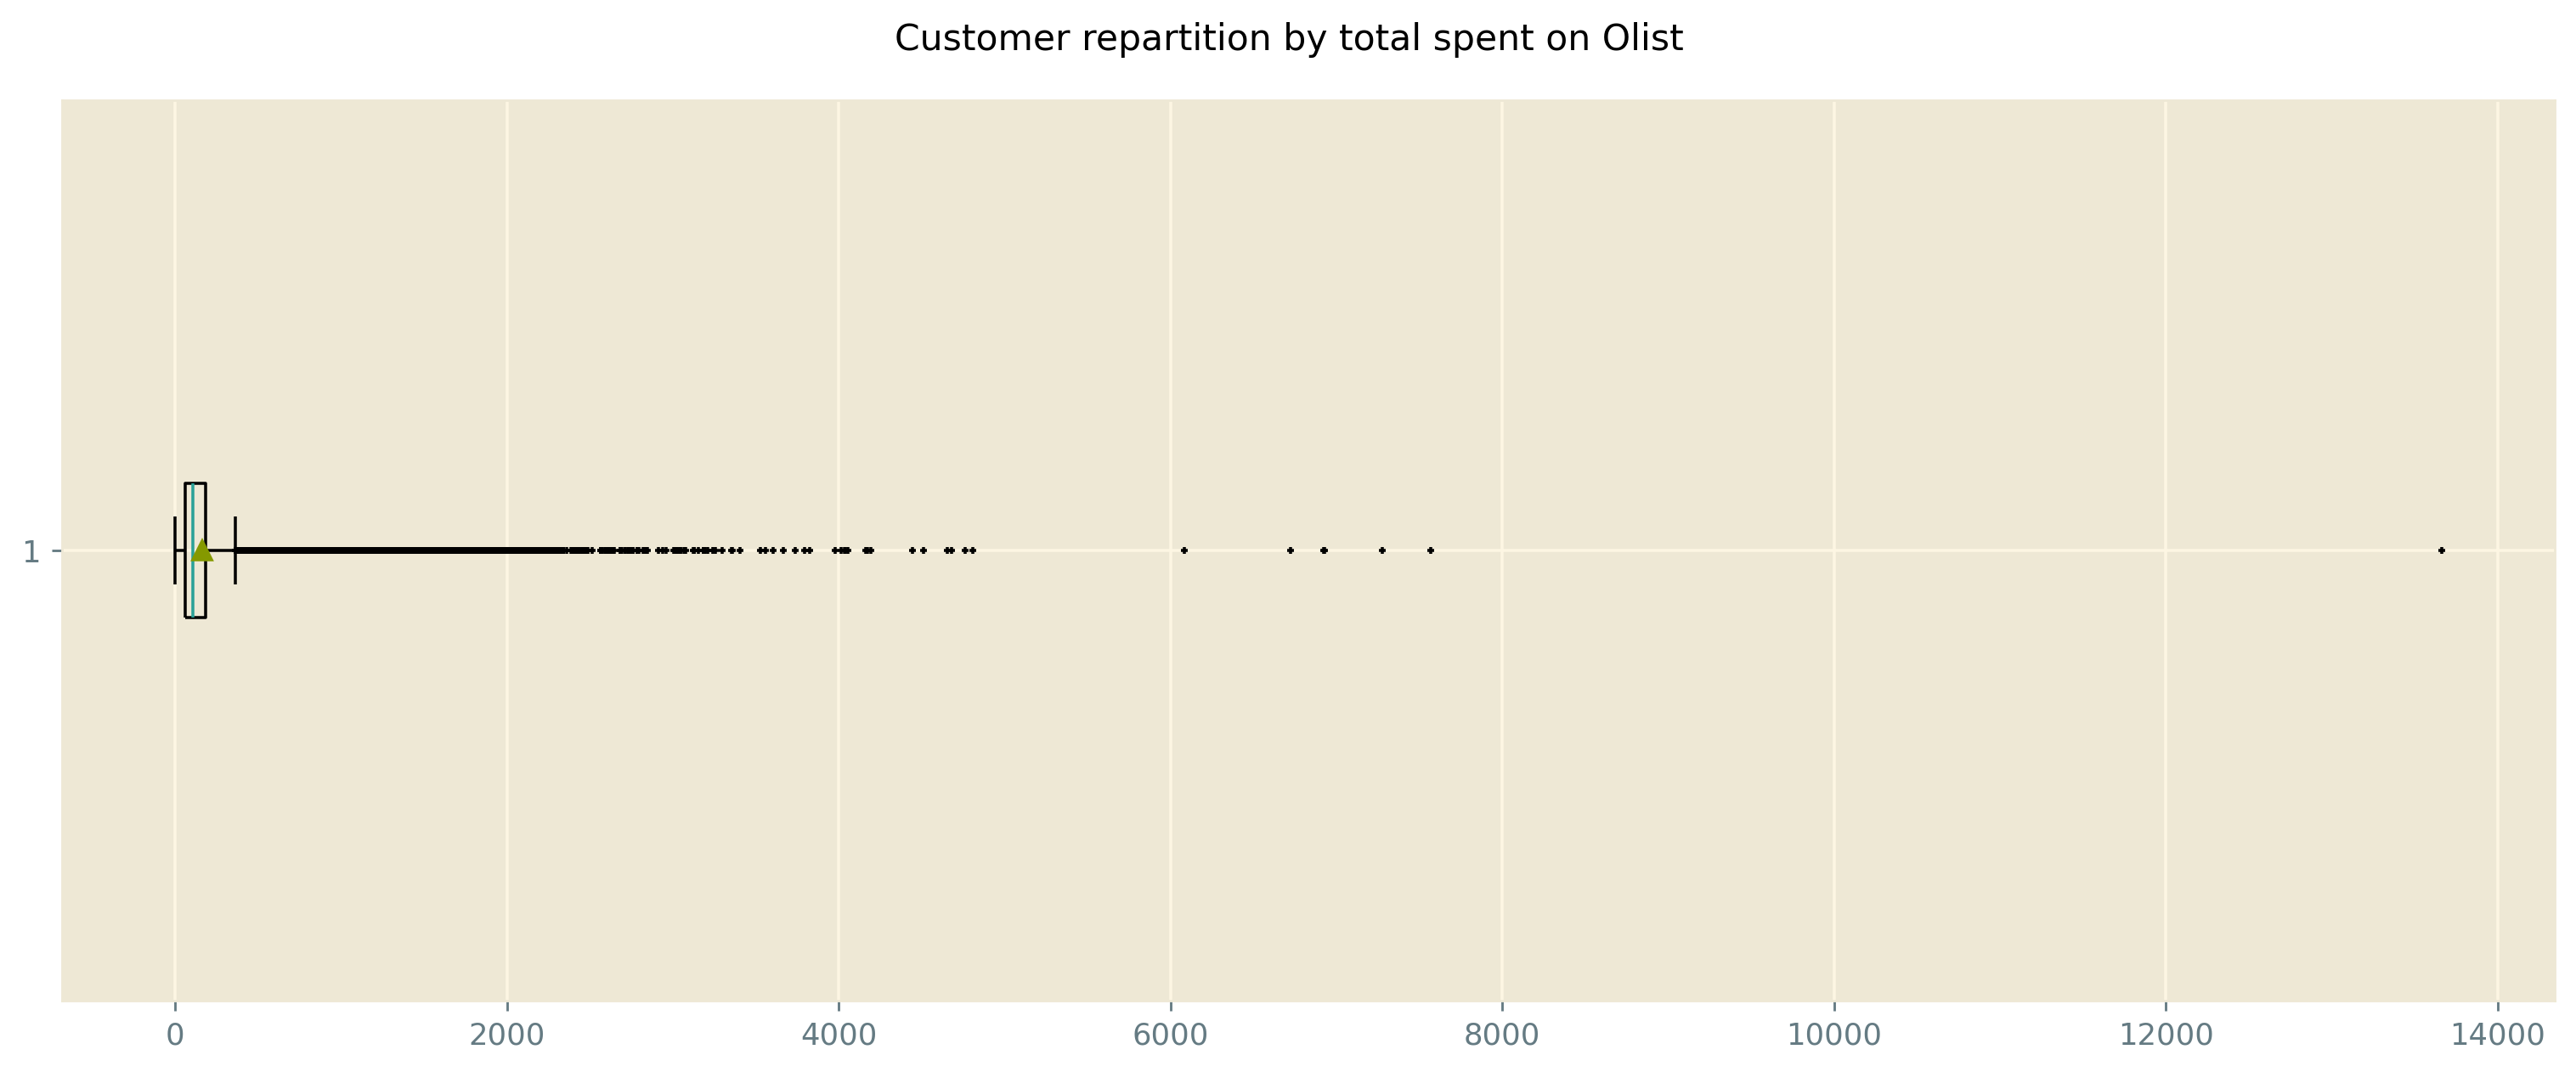

In [29]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12, 5),
    dpi=pc_dpi,
)

flierprops={"marker": "+", "markersize": 2, "markerfacecolor": "navy"}

ax1.boxplot(x="monetary", data=df_rfm, showmeans=True, vert=False, flierprops=flierprops)

###
# Titles/Lables
fig.suptitle("Customer repartition by total spent on Olist")
#
###

fig.tight_layout()
plt.show()


In [30]:
df_rfm["monetary"].value_counts()


0.00      676
77.57     246
35.00     160
73.34     148
116.94    125
         ... 
28.31       1
203.23      1
139.48      1
75.74       1
92.36       1
Name: monetary, Length: 31734, dtype: int64

Lots of zeroes, either purchased is cancelled or refunded. - Lets drop those and zoom on 0 -> 1K

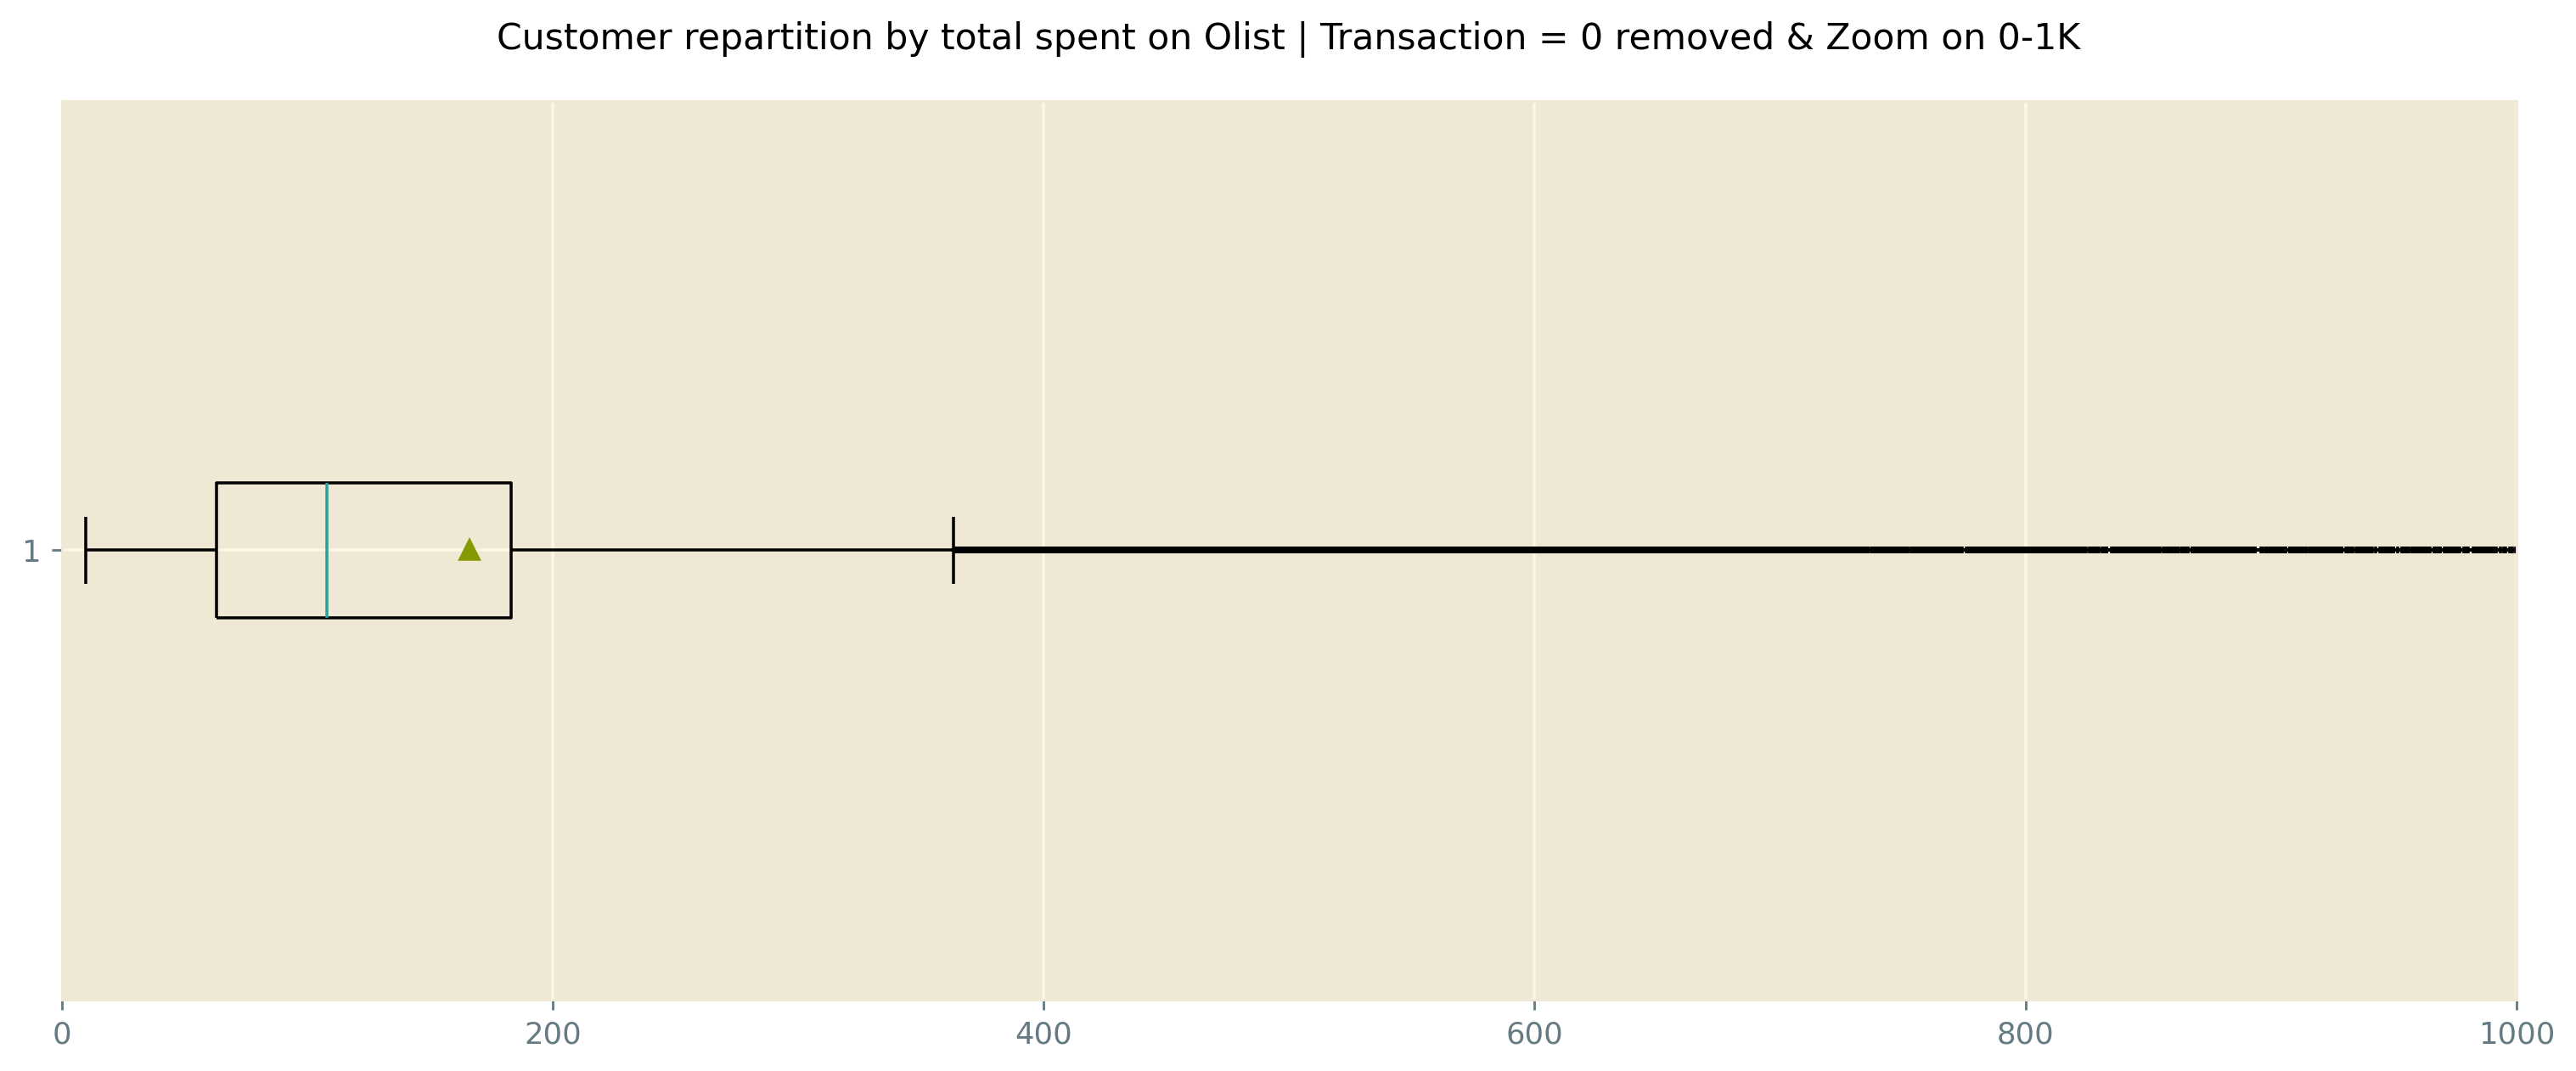

In [31]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12, 5),
    dpi=pc_dpi,
)

flierprops={"marker": "+", "markersize": 2, "markerfacecolor": "navy"}

ax1.boxplot(x="monetary", data=df_rfm[df_rfm["monetary"] != 0.0], showmeans=True, vert=False, flierprops=flierprops)

###
# Titles/Lables
ax1.set_xlim(0, 1000)
fig.suptitle("Customer repartition by total spent on Olist | Transaction = 0 removed & Zoom on 0-1K")
#
###

fig.tight_layout()
plt.show()


In [32]:
# For some reason .describe() does not work here
print("Q1 :", df_rfm["monetary"].quantile(.25))
print("Q3 :", df_rfm["monetary"].quantile(.75))
print("Median :", df_rfm["monetary"].median())
print("Avg. :", np.average(df_rfm["monetary"].values))


Q1 : 62.39
Q3 : 182.2375
Median : 107.27000000000001
Avg. : 164.87214077588146


In [33]:
outliers = df_rfm[df_rfm["monetary"] < 62.39]
outliers = df_rfm[df_rfm["monetary"] > 182.2375]
print("Max :", max(df_rfm["monetary"].values))
print(len(outliers))
del outliers


Max : 13664.08
24024


### Observations :

&emsp;Most clients spend between 62.39 & 182.24 R$ (Assuming it's in Reales and not in Dollars, it's not precised in the dataset and website screenshots show that R$ is used), with the median at 107.28 and an average of 164.88 R$.<br>
&emsp;There is a wide range of outliers (24024) with spendings going from +Q3(182.2375 R$) to 13664.08 R$, but, mostly, outliers spent 4K max with a very small number of customers crossing this line.

- Operating under the assumption that Olist did not provide its whole database dump, early conclusions cannot be drawn.

## 3 : Time Delta between global last order and customer last order

In [34]:
df_rfm.describe()["recency"]


count    9.609600e+04
mean     2.490060e+07
std      1.325517e+07
min      0.000000e+00
25%      1.415973e+07
50%      2.323386e+07
75%      3.433116e+07
max      6.677370e+07
Name: recency, dtype: float64

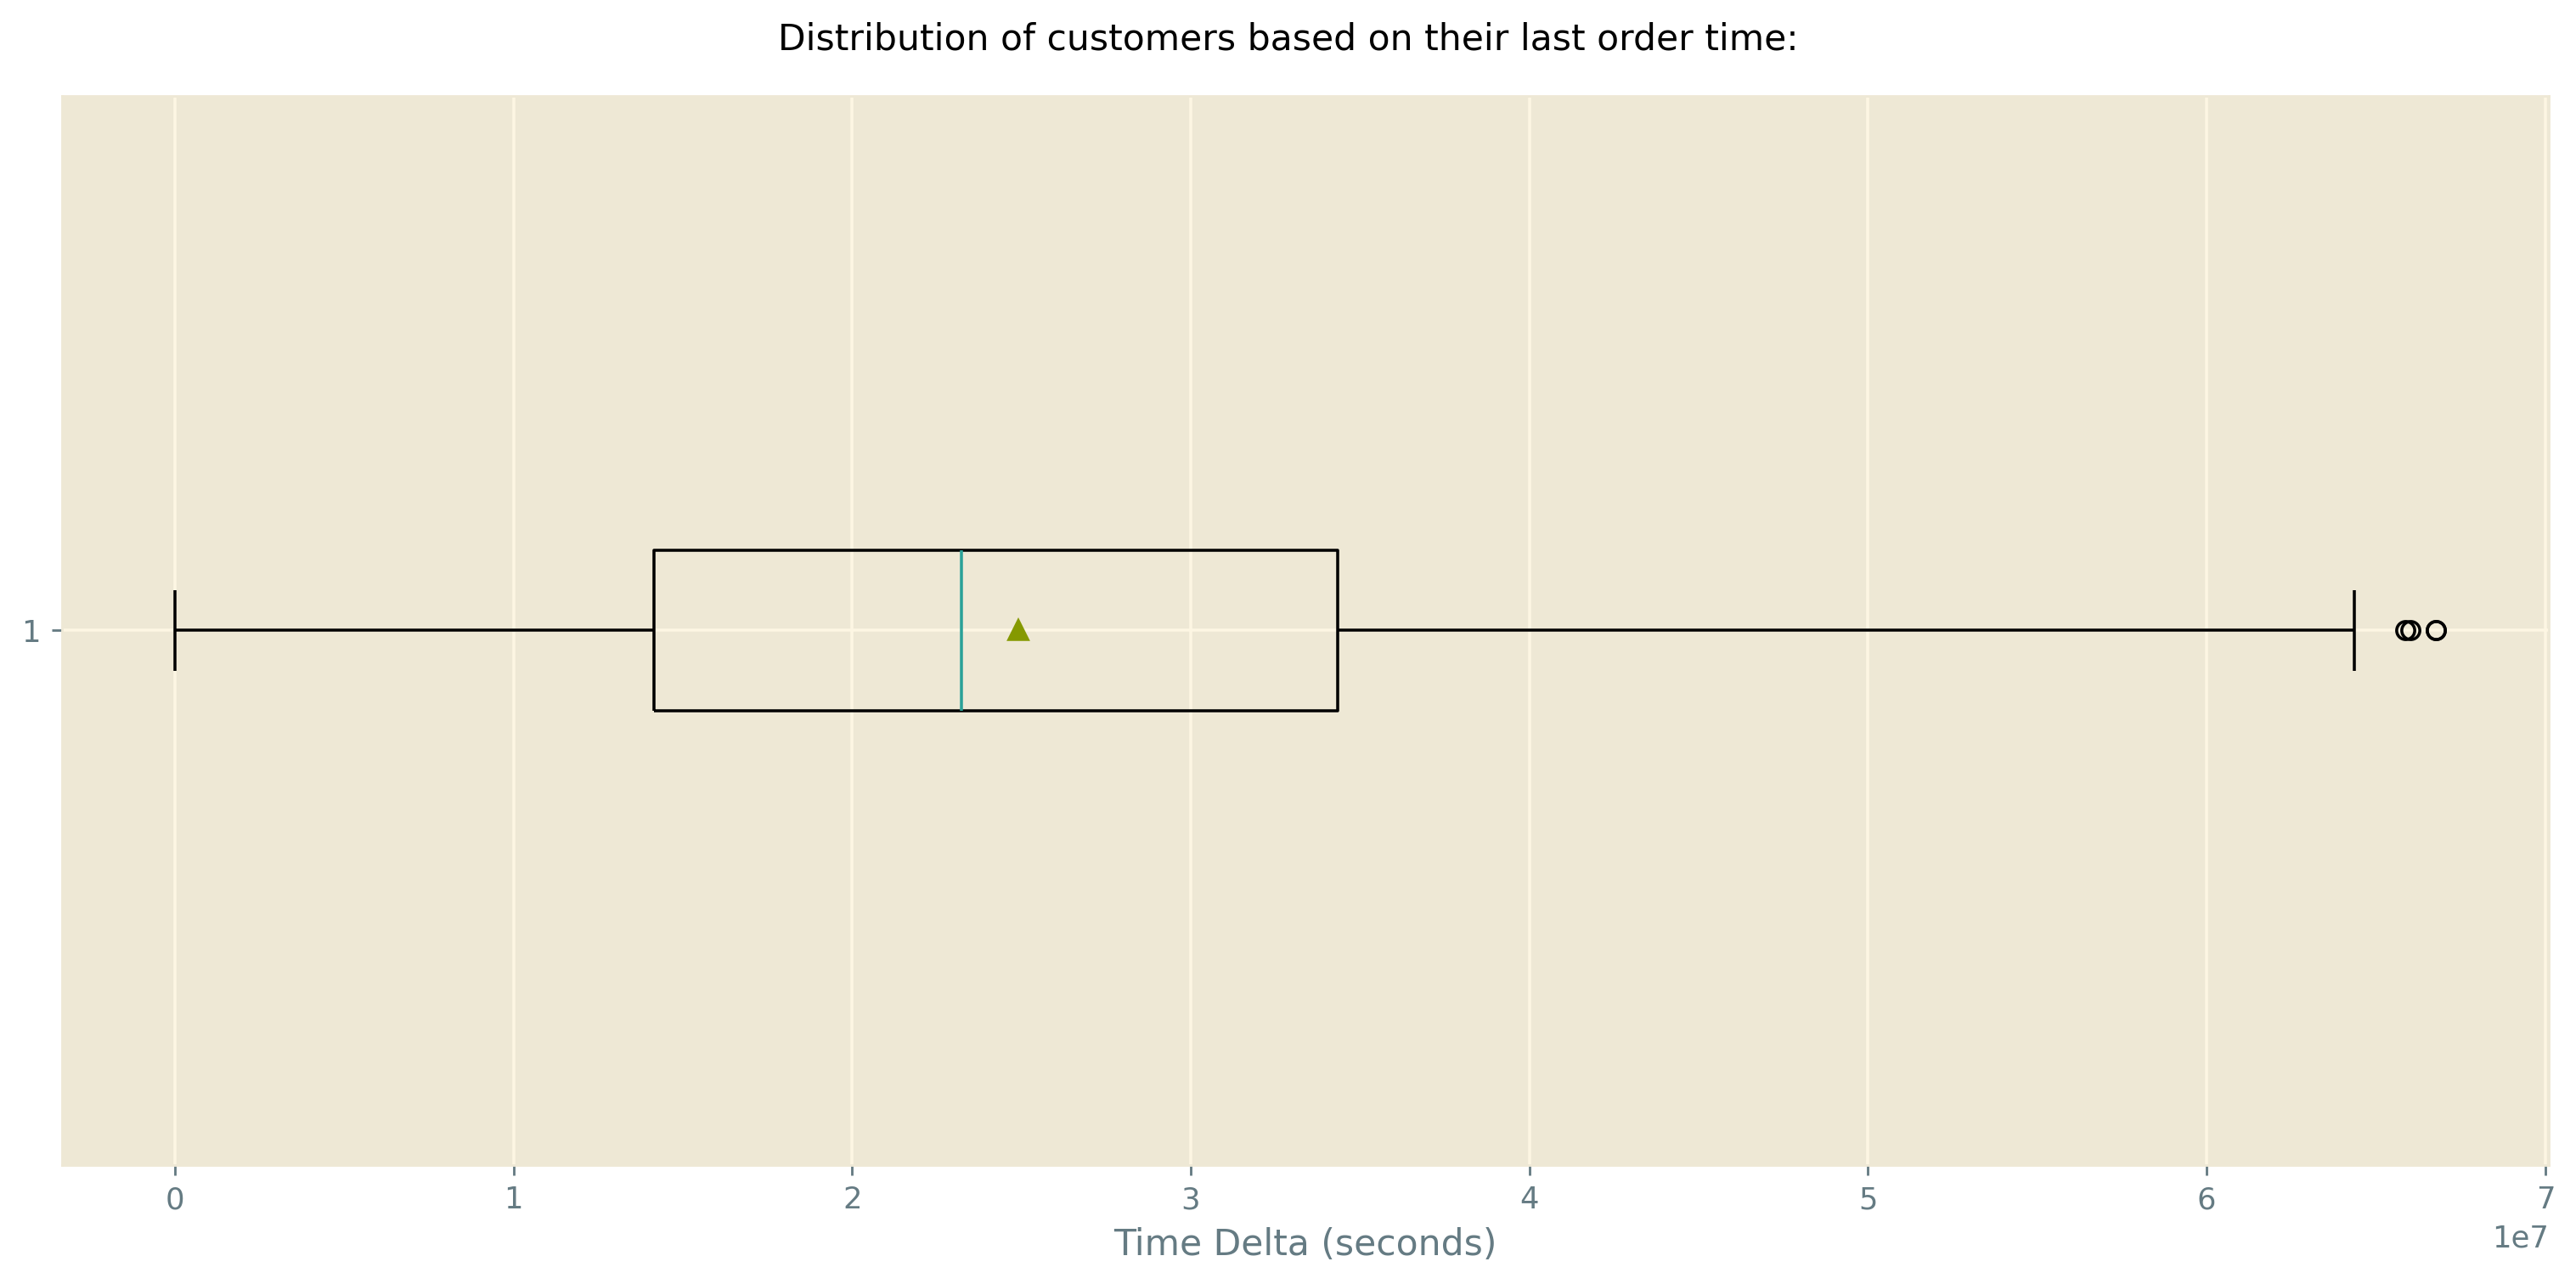

In [35]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12, 6),
    dpi=pc_dpi,
)

ax1.boxplot(x="recency", data=df_rfm, vert=False, showmeans=True)

###
# Titles/Lables
fig.suptitle("Distribution of customers based on their last order time:")
ax1.set_xlabel("Time Delta (seconds)")
#
###

fig.tight_layout()
plt.show()


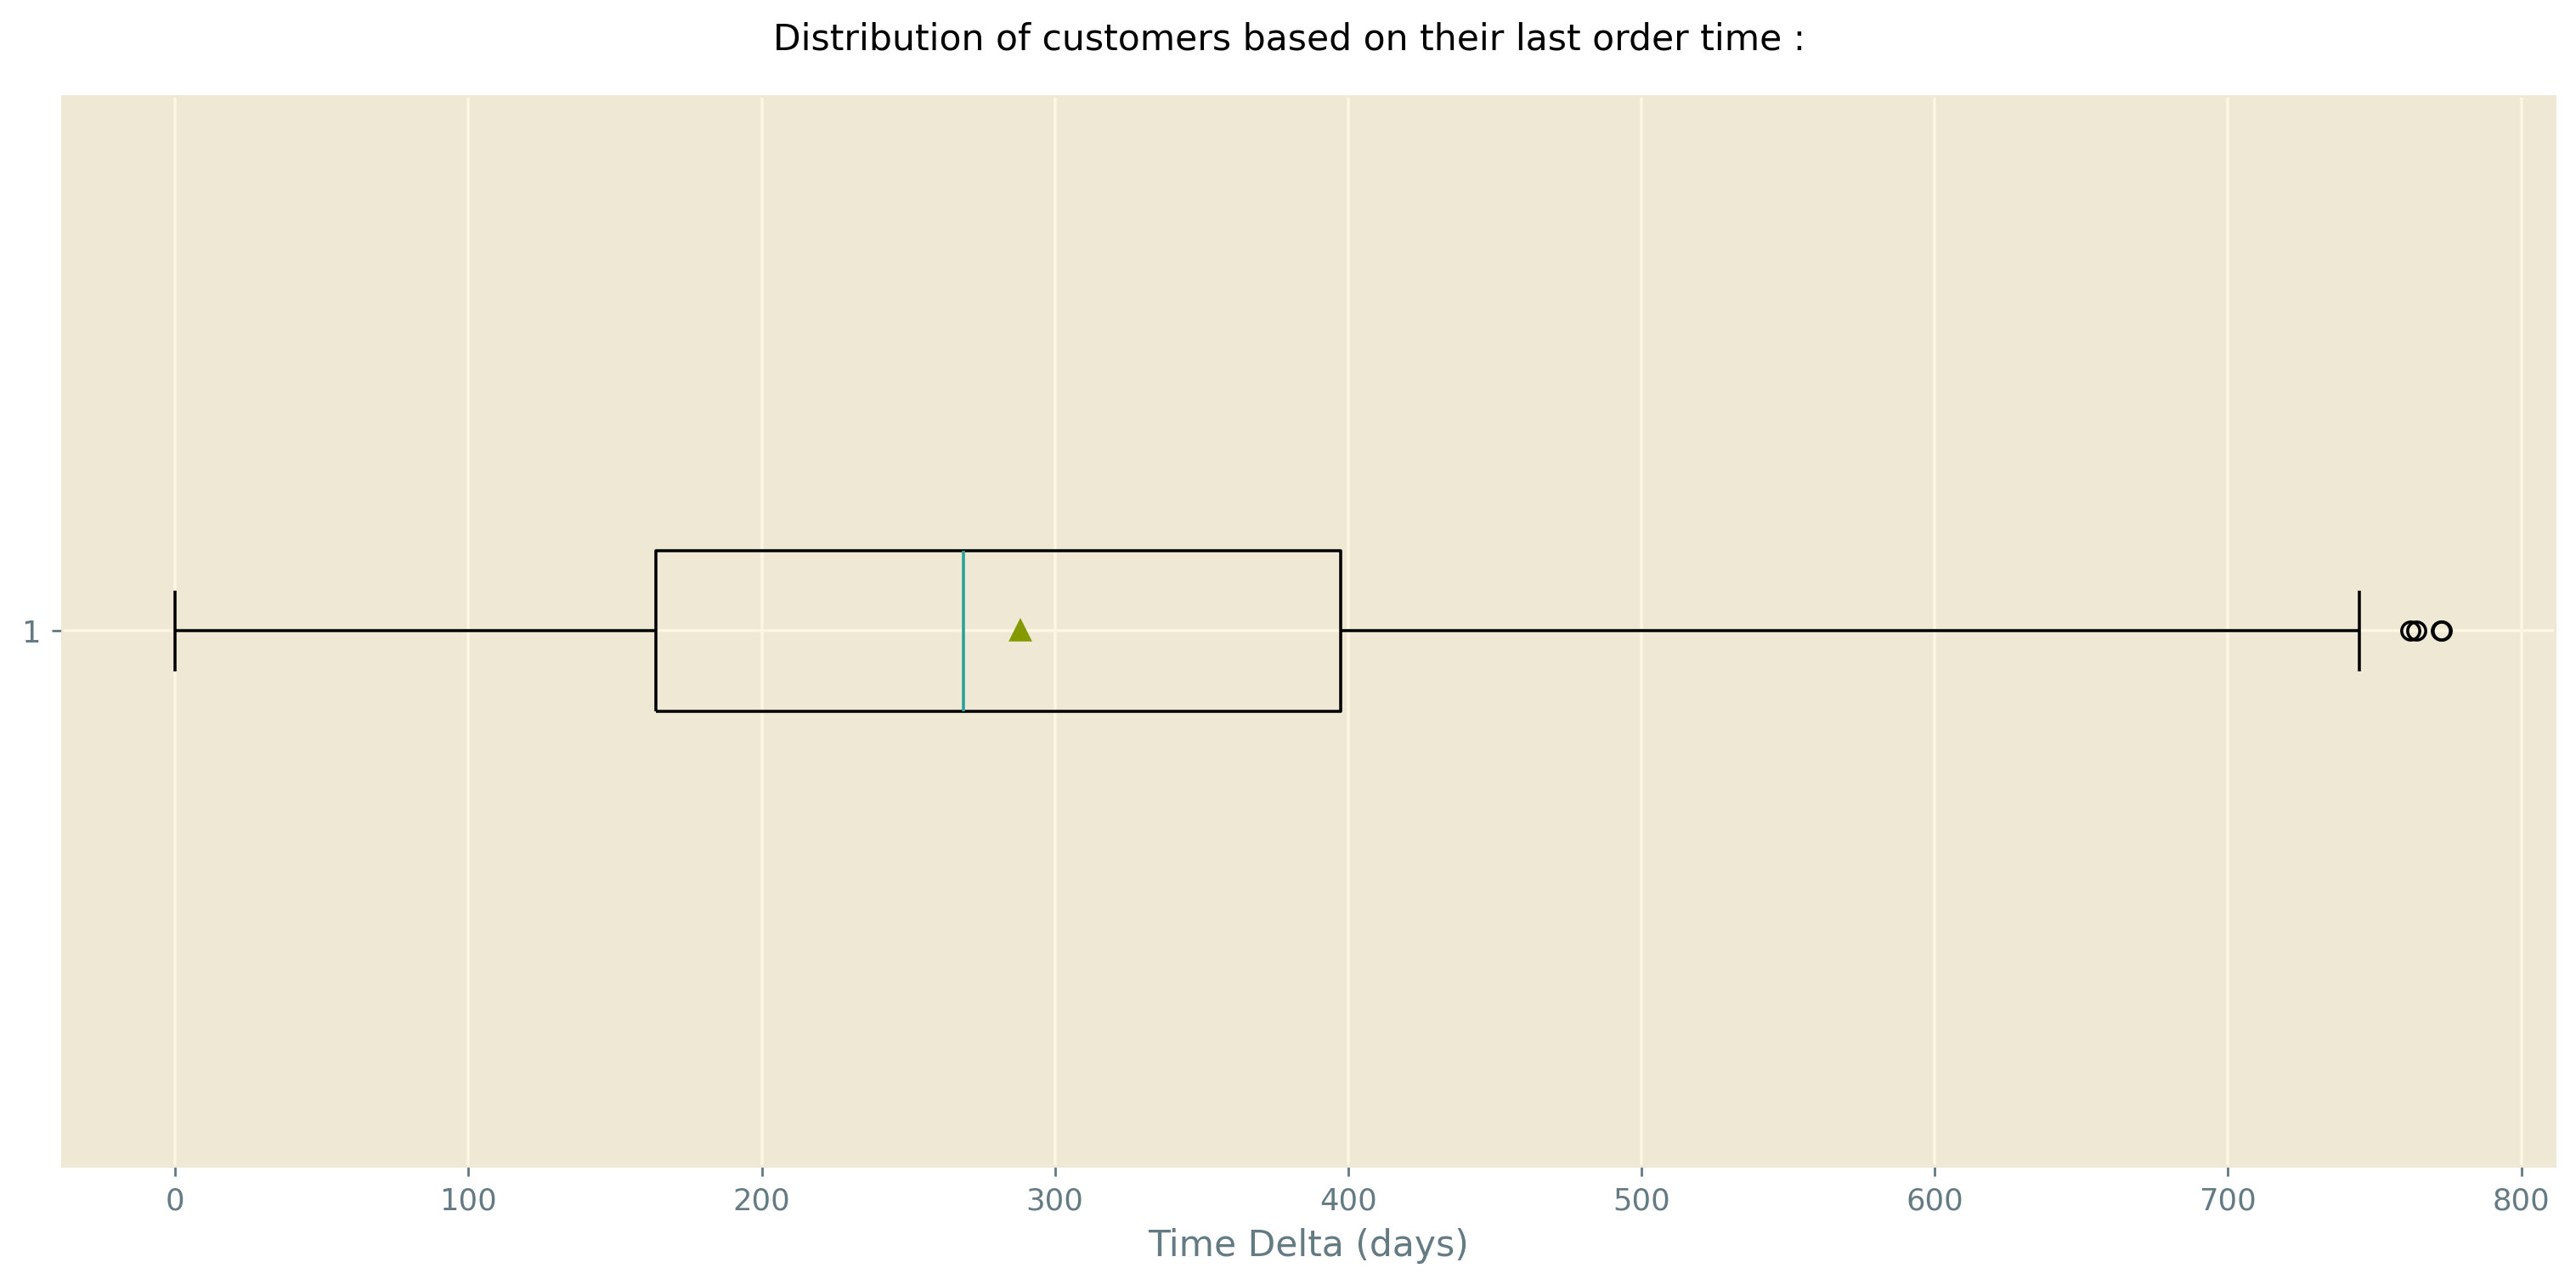

In [36]:
# Not very visual so let's convert seconds to days : 
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12, 6),
    dpi=pc_dpi,
)

deltas = df_rfm["recency"]
deltas_days = np.divide(deltas, 86400)

ax1.boxplot(x=deltas_days, vert=False, showmeans=True)

###
# Titles/Lables
fig.suptitle("Distribution of customers based on their last order time :")
ax1.set_xlabel("Time Delta (days)")
#
###

fig.tight_layout()
plt.show()


In [37]:
deltas_days.describe()


count    96096.000000
mean       288.201370
std        153.416318
min          0.000000
25%        163.885744
50%        268.910440
75%        397.351398
max        772.843738
Name: recency, dtype: float64

### The data that most customers haven't ordered in a while

- 75% of the customers in the database haven't ordered anything in at least the last 164 days (rounded up).
- Operating under the assumption that Olist did not provide its whole database dump, early conclusions cannot be drawn.

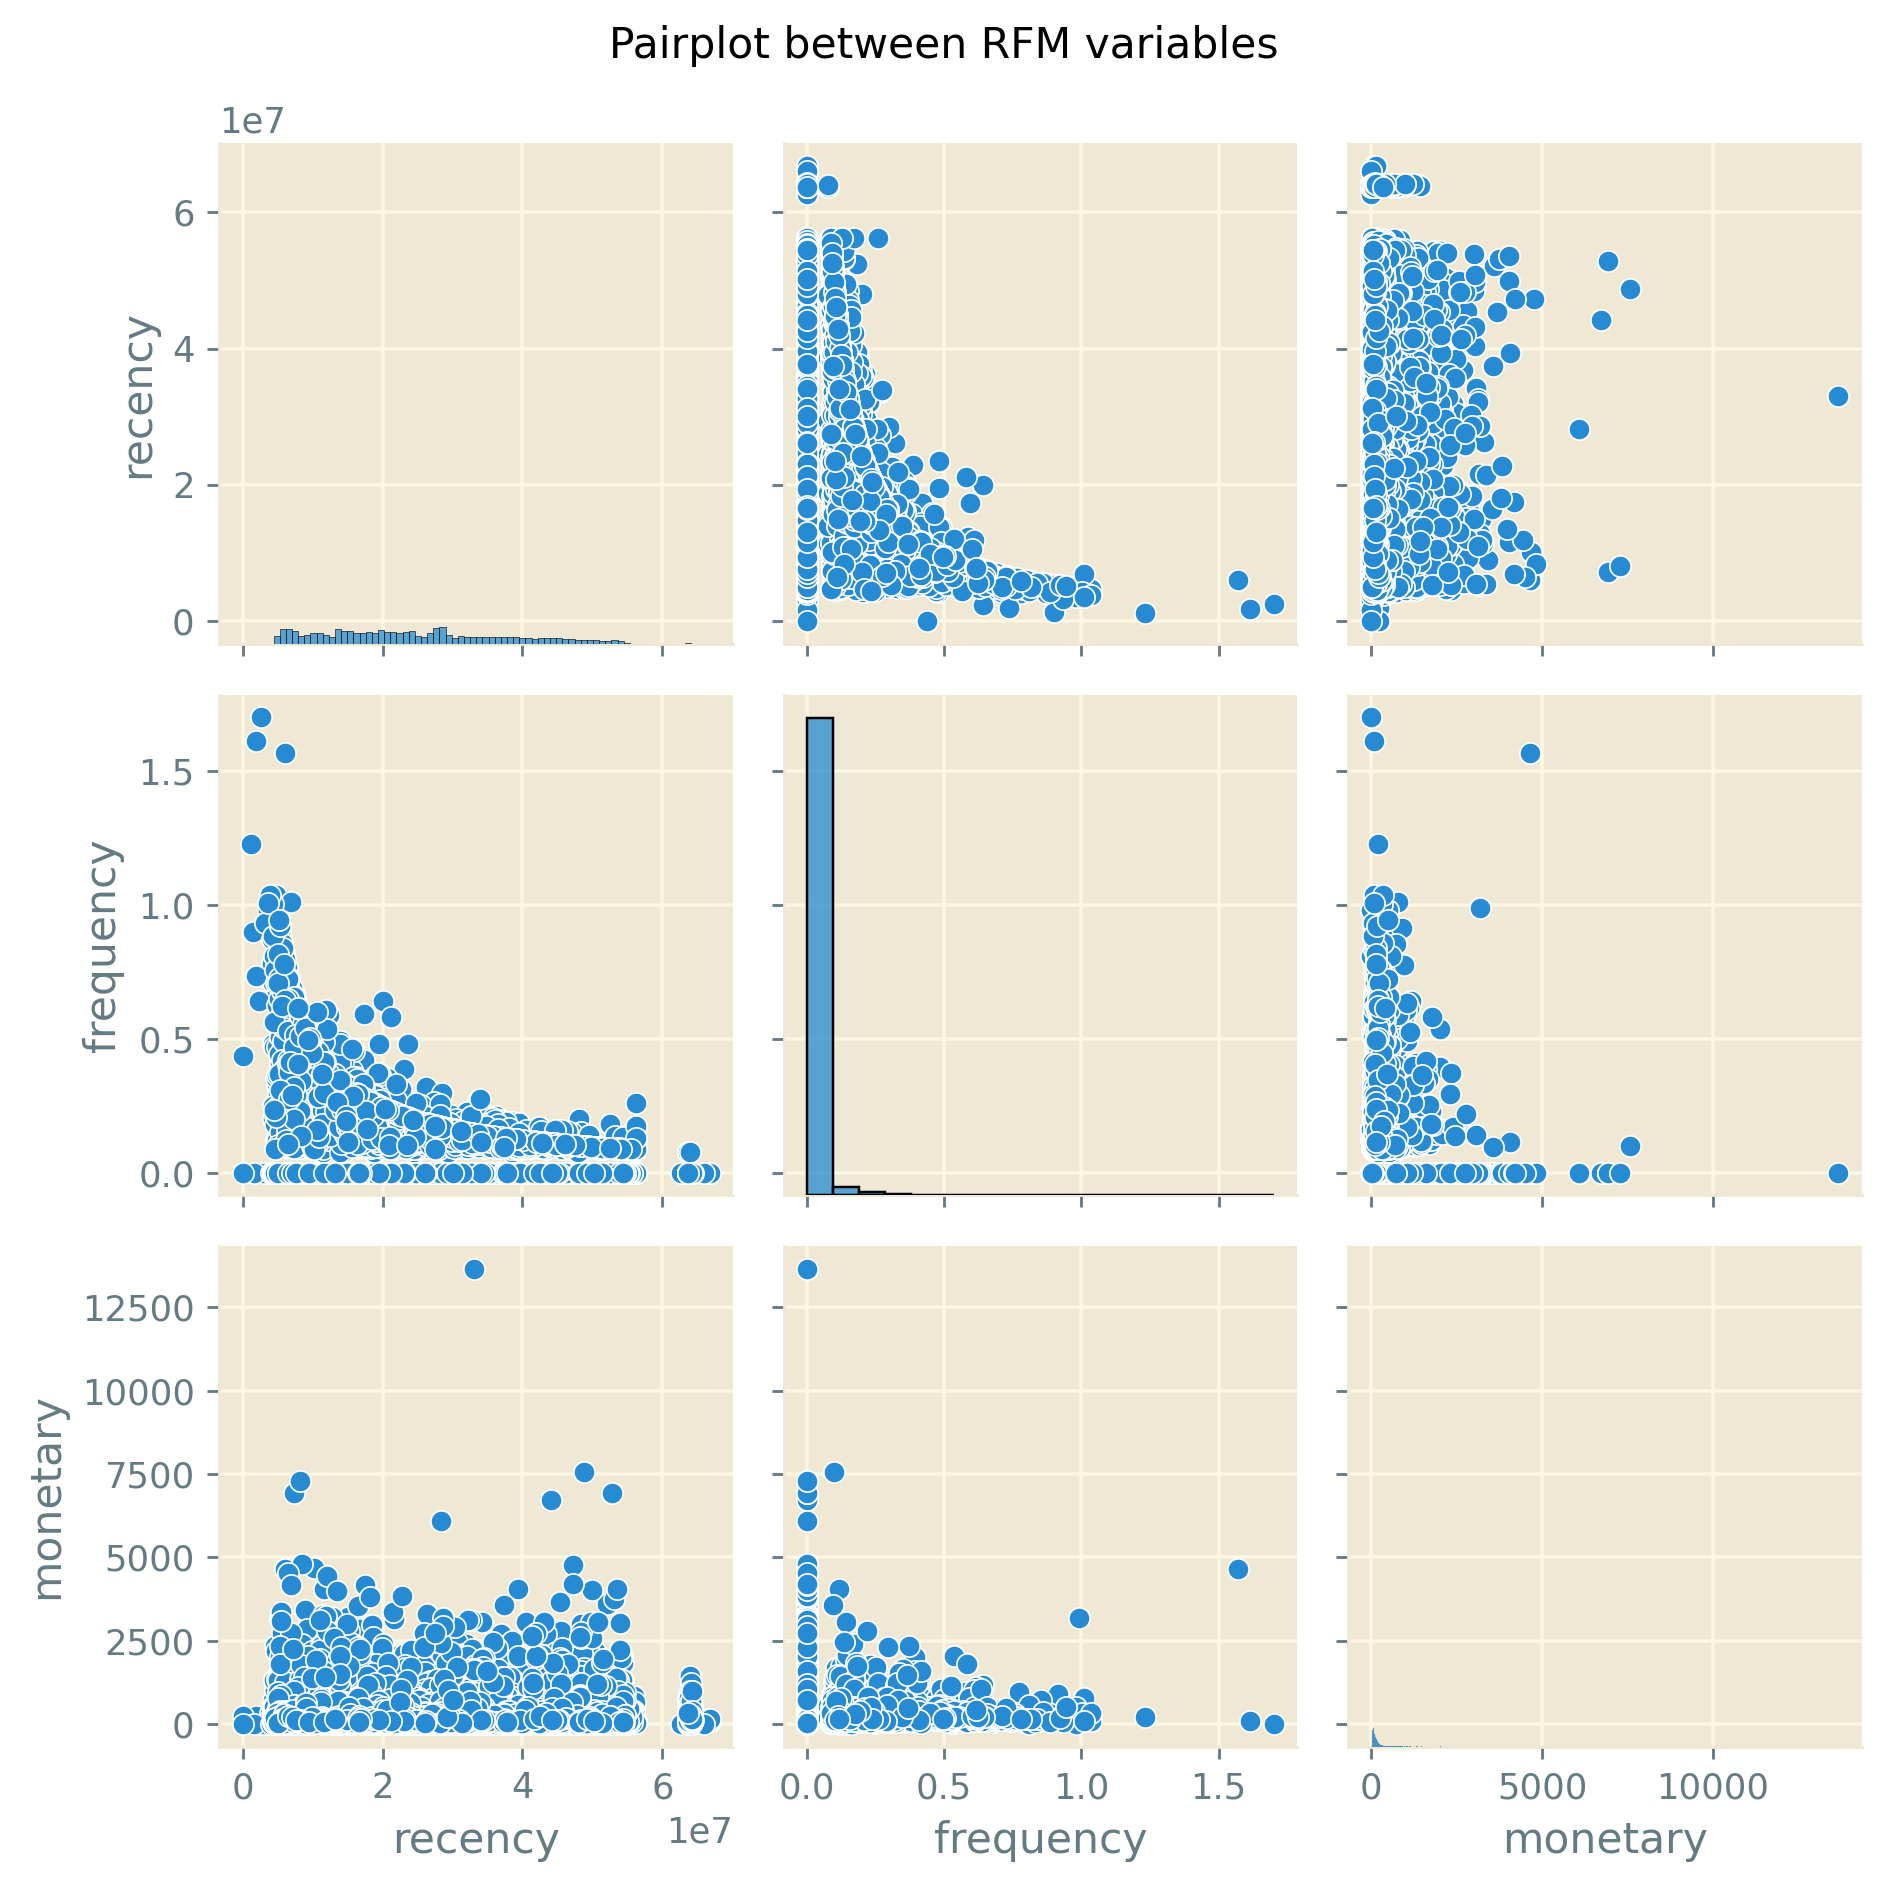

In [38]:
grid = sns.pairplot((df_rfm[["recency", "frequency", "monetary"]]))

grid.figure.figsize = (4, 4)
grid.figure.dpi = pc_dpi

###
# Titles/Lables
grid.figure.suptitle("Pairplot between RFM variables")
#
###
grid.figure.tight_layout()
plt.show()


### Conslusion

&emsp;There are no obvious clusters distinguishable using simply RFM variables and pairploting. 3D Plotting of RFM can be attempted but it seems the data of the 3 variables will not be sufficient to offer what the customer (Olist) is looking for.
&emsp;The Wikipedia page regarding Olist mentions that there are 2M+ unique active customers, so it looks like we only have a small fragment of their database : we know we have 96K accounts and it exists 2M+ accounts, but we are not aware of other useful stastistics, like the number of order, which would explain why our frequency is = 0 in close to 99% of the customers.

## 4 : 3D Visualisation of RFM variables

We hope to obtain visual clusters to identify and classify customers using the MK1 eyeball without any clustering algorithms or data engineering

In [39]:
labels_dict ={
        "recency": "Recency (in seconds)",
        "frequency": "∆ in s between Cx Most recent order & Most recent Global",
        "monetary": "Total Spent on Olist"
    }

marker_style = {
    "color": 'navy',
    "size": 5,
    }

fig = px.scatter_3d(
    data_frame=df_rfm, x="recency",
    y="frequency", z="monetary",
    width=5 * pc_dpi, height=3 * pc_dpi,
    labels=labels_dict,
    )


fig.update_layout(
    margin=dict(l=40, r=40, t=40, b=40),
    title="3D Representation of customers, RFM approach",
)

fig.update_traces(marker=marker_style)

fig.show()


### Unclear

- The most recent "order" is not really an order as it sum total is 0. Maybe it was too recent for the payment for being processed, awaiting further directions for actions on total_spent = 0
- We can clearly see the extremes and what looks like a zone where most Cxs are placed, but the clustering is still unclear.

# <u>4 : Applying classification algorithms (K-Means, DBSCAN, Agglomerative clustering)</u>

> Following the inconclusive results (as expected) of part #3, Machine Learning classification algorithms can be applied to determine if clusters can be found.

## 4.0 : Min Max Scaling the dataset

> 0 -> 10 or 0 -> 5 will be better suited for understanding data like reviews and ratings

In [40]:
mms = MinMaxScaler(feature_range=(0, 10))

dropcols = ["customer_uid", "order_id_list", "most_ancient_order_dt", "most_recent_order_dt"]

df_rfm_mms = df_rfm.drop(columns=dropcols)

keepcols = df_rfm_mms.columns

df_rfm_mms = mms.fit_transform(df_rfm_mms.to_numpy())

df_rfm_mms = pd.DataFrame(df_rfm_mms, columns=keepcols)

df_rfm_mms.head()


recency  frequency  monetary
0  6.716759        0.0  0.107486
1  3.595325        0.0  0.245520
2  1.954565        0.0  0.115434
3  2.821503        0.0  0.126829
4  1.039261        0.0  0.184608

## 4.1 : Using and optimizing k-means clustering

> Trial and error will be used to determine the best k-range to pass to the optimizer


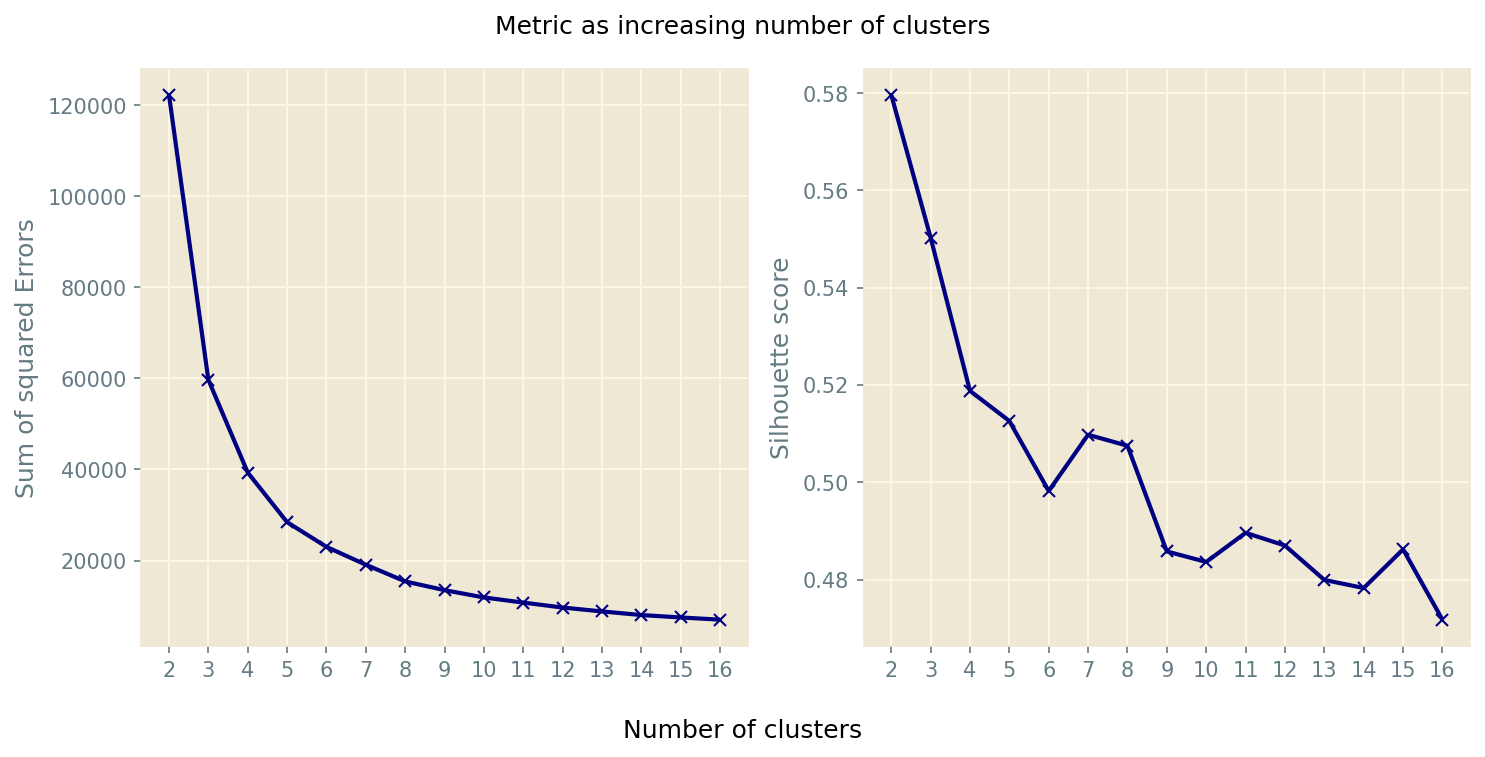

In [41]:
k_range = range(2, 17)

k_means_optimizer(data=df_rfm_mms, k_range=k_range)


#### Observations :

&emsp; 4 seems to be the optimal k-number of clusters, the error keeps diminishing with the increasing number of clusters but the silhouette score is acceptable, performing k-means with k=4 and plotting the results
<br>
><i>It seems the silhouette score calculation is what makes the optimizer takes it's sweet sweet time, if not needed for comparison, it can be considered to rely solely on intertia</i>

In [42]:
km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(df_rfm_mms)

df_rfm_mms["cluster"] = y_predicted


In [46]:
labels_dict ={
        "recency": "Recency",
        "frequency": "Frequncy of purchase(s)",
        "monetary": "Total Spent on Olist"
    }

marker_style = {
    "size": 5,
    }

fig = px.scatter_3d(
    data_frame=df_rfm_mms, x="recency",
    y="frequency", z="monetary", color="cluster",
    width=4 * pc_dpi, height=3 * pc_dpi,
    labels=labels_dict,
    )


fig.update_layout(
    margin=dict(l=40, r=40, t=40, b=40),
    title="3D Representation of customers, RFM approach, k-means clustering",
)

fig.update_traces(marker=marker_style)

fig.show()
